In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from sklearn.model_selection import train_test_split
import re
import seaborn as sns
import matplotlib.pyplot as plt


import nltk
nltk.download("stopwords")
from nltk.stem.porter import *
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

pd.options.plotting.backend = "plotly"

from keras.layers import LSTM, Dense, Embedding
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD, RMSprop
from keras.callbacks import EarlyStopping

%matplotlib inline


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ismaelegorgoglione/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
df = pd.read_csv("../Dataset/new_data.csv", encoding="ISO-8859-1")

In [39]:
# MAP sentiment
label = {"positive": 2, "neutral": 1, "negative": 0}
df["sentiment"] = df["sentiment"].map(label)

# Preprocessing

In [40]:
tfidfconverter = CountVectorizer(max_features=5000, min_df=10, stop_words="english", lowercase=True)
X = tfidfconverter.fit_transform(df["news"]).toarray()

### Train & Test Split

In [41]:
y = pd.get_dummies(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (2541, 1007) (2541, 3)
Validation Set -> (847, 1007) (847, 3)
Test Set -> (1452, 1007) (1452, 3)


In [42]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Bidirectional LSTM Using NN

In [43]:
vocab_size = 5000
embedding_size = 32
epochs=50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

In [44]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          160000    
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          3104      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                

In [45]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/50
40/40 [==============================] - 33s 660ms/step - loss: 0.9720 - accuracy: 0.5856 - precision_2: 0.6004 - recall_2: 0.3530 - val_loss: 0.9229 - val_accuracy: 0.6009 - val_precision_2: 0.6009 - val_recall_2: 0.6009
Epoch 2/50
40/40 [==============================] - 24s 587ms/step - loss: 0.9375 - accuracy: 0.5911 - precision_2: 0.5895 - recall_2: 0.5521 - val_loss: 0.9232 - val_accuracy: 0.6009 - val_precision_2: 0.6009 - val_recall_2: 0.6009
Epoch 3/50
40/40 [==============================] - 15s 368ms/step - loss: 0.9310 - accuracy: 0.5911 - precision_2: 0.5960 - recall_2: 0.5643 - val_loss: 0.9109 - val_accuracy: 0.6009 - val_precision_2: 0.6111 - val_recall_2: 0.5974
Epoch 4/50
40/40 [==============================] - 14s 356ms/step - loss: 0.9135 - accuracy: 0.5923 - precision_2: 0.6255 - recall_2: 0.5356 - val_loss: 0.8757 - val_accuracy: 0.6163 - val_precision_2: 0.6538 - val_recall_2: 0.5596
Epoch 5/50
40/40 [==============================] - 17s 425ms/step -

### Model Accuracy & Loss

In [46]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.6185
Precision : 0.6385
Recall    : 0.5413
F1 Score  : 0.5859


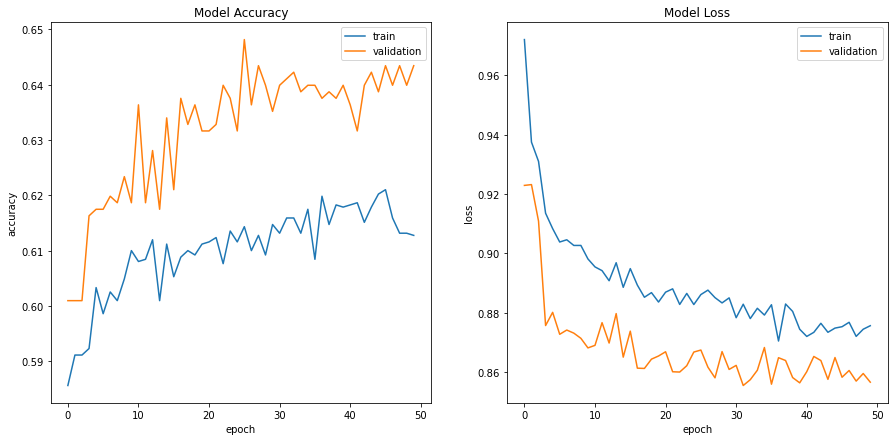

In [47]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(15,7))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

### Model Confusion Matrix

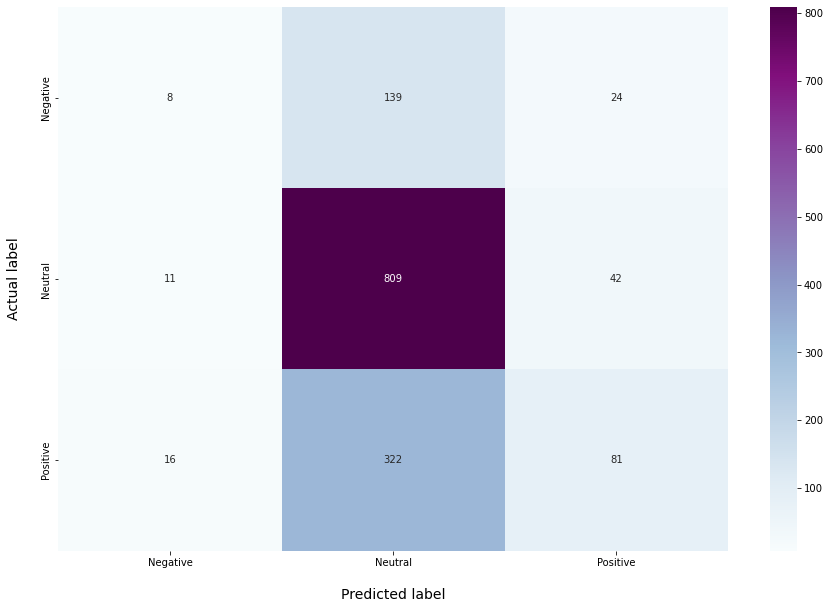

In [48]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, cmap="BuPu", annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    #plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('\nPredicted label', fontsize=14)
    plt.ylabel('Actual label\n', fontsize=14)
    
plot_confusion_matrix(model, X_test, y_test)

# NN update with early stopping

NN is overfitting, we can apply early stops to overcome the problem

In [49]:
es = EarlyStopping(monitor='val_loss', patience=10)
history_es = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, 
                      batch_size=64, callbacks=[es]).history                     

Epoch 1/50
40/40 [==============================] - 17s 417ms/step - loss: 0.8724 - accuracy: 0.6179 - precision_2: 0.6502 - recall_2: 0.5545 - val_loss: 0.8617 - val_accuracy: 0.6364 - val_precision_2: 0.6729 - val_recall_2: 0.5490
Epoch 2/50
40/40 [==============================] - 25s 635ms/step - loss: 0.8686 - accuracy: 0.6187 - precision_2: 0.6530 - recall_2: 0.5466 - val_loss: 0.8561 - val_accuracy: 0.6423 - val_precision_2: 0.6722 - val_recall_2: 0.5691
Epoch 3/50
40/40 [==============================] - 23s 568ms/step - loss: 0.8682 - accuracy: 0.6246 - precision_2: 0.6520 - recall_2: 0.5435 - val_loss: 0.8606 - val_accuracy: 0.6411 - val_precision_2: 0.6657 - val_recall_2: 0.5431
Epoch 4/50
40/40 [==============================] - 20s 515ms/step - loss: 0.8686 - accuracy: 0.6218 - precision_2: 0.6510 - recall_2: 0.5573 - val_loss: 0.8699 - val_accuracy: 0.6316 - val_precision_2: 0.6700 - val_recall_2: 0.5608
Epoch 5/50
40/40 [==============================] - 19s 469ms/step -

In [50]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.6150
Precision : 0.6356
Recall    : 0.5503
F1 Score  : 0.5899


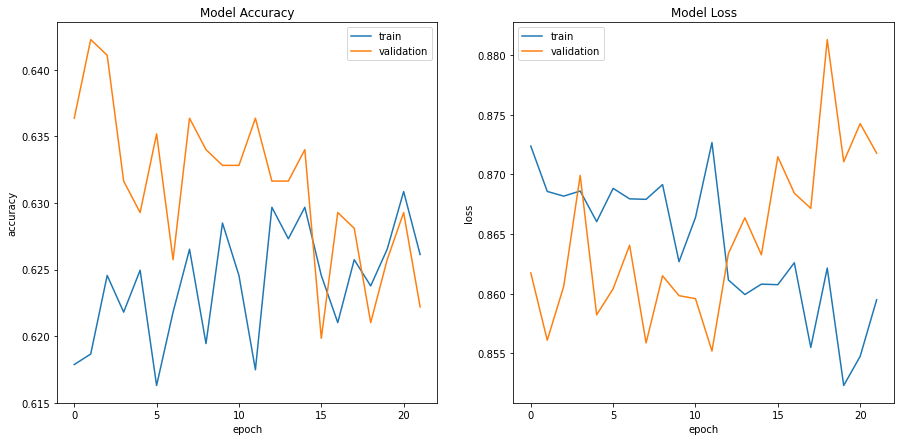

In [51]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(15,7))
    # first plot
    ax[0].plot(history['accuracy'])
    ax[0].plot(history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history['loss'])
    ax[1].plot(history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history_es)

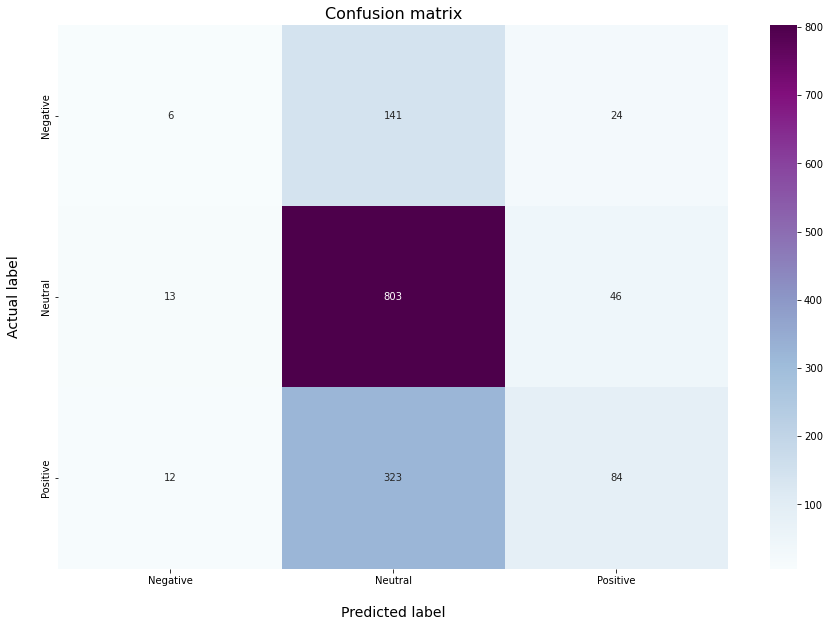

In [52]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(15,10))
    sns.heatmap(cm, cmap="BuPu", annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('\nPredicted label', fontsize=14)
    plt.ylabel('Actual label\n', fontsize=14)
    
plot_confusion_matrix(model, X_test, y_test)